In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
cudnn.benchmark = True
plt.ion()

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
import torch
from tools.sam import SAM
import timm

In [38]:
test_path = 'test'

In [39]:
#model = timm.create_model('vit_large_patch16_224.orig_in21k', pretrained=True).to(device)

In [40]:
'''
model.eval()
data_config = timm.data.resolve_model_data_config(model)
auto_transforms = timm.data.create_transform(**data_config, is_training=False)
auto_transforms
'''

'\nmodel.eval()\ndata_config = timm.data.resolve_model_data_config(model)\nauto_transforms = timm.data.create_transform(**data_config, is_training=False)\nauto_transforms\n'

In [41]:
model = torch.hub.load("facebookresearch/swag", model="vit_h14_in1k")

Using cache found in C:\Users\Jason/.cache\torch\hub\facebookresearch_swag_main


In [42]:
train_transform = transforms.Compose([
    transforms.Resize(
        518,
        interpolation=transforms.InterpolationMode.BICUBIC,
    ),
    transforms.CenterCrop(518),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    ),
])

In [43]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.Lambda(lambda img: train_transform(img)),
        transforms.RandomErasing()
    ]),
    'val': train_transform,
}

In [44]:
data_dir = 'split_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

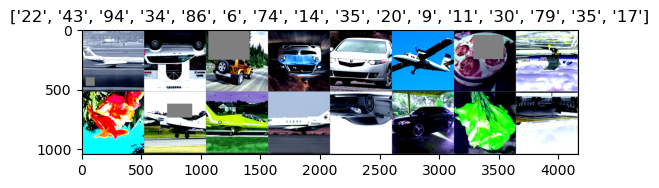

In [45]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [46]:
from torchinfo import summary

summary(model, input_size=(16, 3, 518, 518), col_names=["input_size", "output_size","trainable"])

Layer (type:depth-idx)                             Input Shape               Output Shape              Trainable
ViTH14                                             [16, 3, 518, 518]         [16, 1000]                True
├─Conv2d: 1-1                                      [16, 3, 518, 518]         [16, 1280, 37, 37]        True
├─Encoder: 1-2                                     [1370, 16, 1280]          [1370, 16, 1280]          True
│    └─Dropout: 2-1                                [1370, 16, 1280]          [1370, 16, 1280]          --
│    └─Sequential: 2-2                             [1370, 16, 1280]          [1370, 16, 1280]          True
│    │    └─EncoderBlock: 3-1                      [1370, 16, 1280]          [1370, 16, 1280]          True
│    │    └─EncoderBlock: 3-2                      [1370, 16, 1280]          [1370, 16, 1280]          True
│    │    └─EncoderBlock: 3-3                      [1370, 16, 1280]          [1370, 16, 1280]          True
│    │    └─EncoderBlock:

In [47]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

class_token
conv_proj.weight
conv_proj.bias
encoder.pos_embedding
encoder.layers.layer_0.ln_1.weight
encoder.layers.layer_0.ln_1.bias
encoder.layers.layer_0.self_attention.in_proj_weight
encoder.layers.layer_0.self_attention.in_proj_bias
encoder.layers.layer_0.self_attention.out_proj.weight
encoder.layers.layer_0.self_attention.out_proj.bias
encoder.layers.layer_0.ln_2.weight
encoder.layers.layer_0.ln_2.bias
encoder.layers.layer_0.mlp.linear_1.weight
encoder.layers.layer_0.mlp.linear_1.bias
encoder.layers.layer_0.mlp.linear_2.weight
encoder.layers.layer_0.mlp.linear_2.bias
encoder.layers.layer_1.ln_1.weight
encoder.layers.layer_1.ln_1.bias
encoder.layers.layer_1.self_attention.in_proj_weight
encoder.layers.layer_1.self_attention.in_proj_bias
encoder.layers.layer_1.self_attention.out_proj.weight
encoder.layers.layer_1.self_attention.out_proj.bias
encoder.layers.layer_1.ln_2.weight
encoder.layers.layer_1.ln_2.bias
encoder.layers.layer_1.mlp.linear_1.weight
encoder.layers.layer_1.mlp.line

In [48]:
for param in model.parameters():
    param.requires_grad = False

for param in model.head.parameters():
    param.requires_grad = True


model.head = torch.nn.Linear(1280, 100).to(device)

for name, param in model.named_parameters():
    if "layer_31" in name or 'layer_30' in name:
        param.requires_grad = True

model = model.to(device)

summary(model, input_size=(16, 3, 518, 518), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
ViTH14                                             [16, 3, 518, 518]         [16, 100]                 1,280                     Partial
├─Conv2d: 1-1                                      [16, 3, 518, 518]         [16, 1280, 37, 37]        (753,920)                 False
├─Encoder: 1-2                                     [1370, 16, 1280]          [1370, 16, 1280]          1,753,600                 Partial
│    └─Dropout: 2-1                                [1370, 16, 1280]          [1370, 16, 1280]          --                        --
│    └─Sequential: 2-2                             [1370, 16, 1280]          [1370, 16, 1280]          --                        Partial
│    │    └─EncoderBlock: 3-1                      [1370, 16, 1280]          [1370, 16, 1280]          (19,677,440)              False
│    │    └─EncoderBlock: 3-2                   

In [49]:
criterion = nn.CrossEntropyLoss()

base_optimizer = torch.optim.SGD 
optimizer_conv = SAM(model.parameters(), base_optimizer, lr=0.004, momentum=0.9, rho=1.75)

In [50]:
from tools.engine import sam_train
from tools.test_tracking import create_writer
writer = create_writer('ViT_Huge_FB_2Unfrozen_RandomErasing')
save_path = 'models/ViT_Huge_FB_2Unfrozen_RandomErasing'

In [51]:
sam_train(model=model, train_loader=dataloaders['train'], test_loader=dataloaders['val'], loss_fn=criterion, optimizer=optimizer_conv, num_epochs=40, writer=writer, save_path=save_path)

  0%|          | 0/40 [00:00<?, ?it/s]

({'train_loss': [0.23408105075359345,
   0.10934258058667183,
   0.08435187287628651,
   0.0641450186446309,
   0.05410082656890154,
   0.04619923496618867,
   0.042212824737653136,
   0.03569776751101017,
   0.038342050723731515,
   0.03257198629900813,
   0.027499675638973712,
   0.02904887850396335,
   0.02440037745051086,
   0.02605474601034075,
   0.019287438262254,
   0.02388705374673009,
   0.019561474155634643,
   0.017347924606874586,
   0.016222681743092836,
   0.018368783947080372,
   0.01644237698521465,
   0.01725013090064749,
   0.01711155766155571,
   0.014309058263897896,
   0.013612932502292096,
   0.015222515019122512,
   0.01305125752929598,
   0.014407451786100865,
   0.012331305700354279,
   0.013018121712375432,
   0.009834252675063907,
   0.01169149125693366,
   0.011267540804110467,
   0.01049668044084683,
   0.011548938744235784,
   0.01148003968410194,
   0.009793514818884432,
   0.01007856745738536,
   0.010040016476996243,
   0.00905014440882951],
  'train_a

In [60]:
# try model on test data, and save the results in a csv file. left column is the image name, right column is the predicted class
import pandas as pd
import os
from PIL import Image
from torchvision import transforms

def test_model(model, test_path):
    model.eval()
    test_images = os.listdir(test_path)
    results = []
    for image in test_images:
        img_path = os.path.join(test_path, image)
        img = Image.open(img_path).convert('RGB')
        img = data_transforms['val'](img)
        img = img.unsqueeze(0)
        img = img.to(device)
        output = model(img)
        _, preds = torch.max(output, 1)
        results.append([image, class_names[preds.item()]])
    return results

results = test_model(model, test_path)
df = pd.DataFrame(results, columns=['ID', 'Label'])
df.to_csv('predictions.csv', index=False)



AttributeError: 'NoneType' object has no attribute 'eval'